In [1]:
#Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import multivariate_normal
from scipy.ndimage import label
from scipy.ndimage import map_coordinates

%matplotlib inline

### 1.1.1

In [2]:
#Load first image of the video 

Im = cv2.imread(".\\cv23_lab2_material\\part1 - GreekSignLanguage\\1.png")
YCrCbIm = cv2.cvtColor(Im, cv2.COLOR_BGR2YCR_CB)

print("Image loaded as: ", type(YCrCbIm))

print("Resolution: ", YCrCbIm.shape)
print("Range: %d - %d " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350, 3)
Range: 2 - 240 


In [3]:
# Normalize to [0,1]
YCrCbIm = YCrCbIm.astype(float)/np.max(YCrCbIm)

print("Range: %f - %f " % (np.min(YCrCbIm), np.max(YCrCbIm)))

Range: 0.008333 - 1.000000 


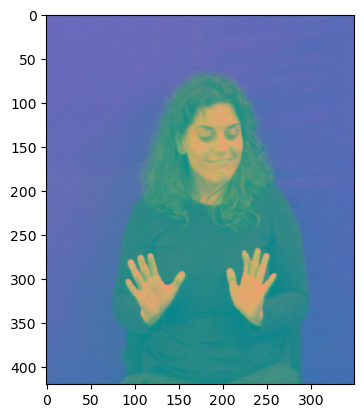

In [4]:
# Show image YCrCb colour space

plt.imshow(YCrCbIm)
plt.show()

In [5]:
# Load skin samples

mat = scipy.io.loadmat('.\\cv23_lab2_material\\part1 - GreekSignLanguage\\skinSamplesRGB.mat')
Skin_samples = mat['skinSamplesRGB']

YCrCb_Skin_samples = cv2.cvtColor(Skin_samples, cv2.COLOR_RGB2YCR_CB)

# Normalize to [0,1]
YCrCb_Skin_samples = YCrCb_Skin_samples.astype(float)/np.max(YCrCb_Skin_samples)

print(YCrCb_Skin_samples.shape)
print("Range: %f - %f " % (np.min(YCrCb_Skin_samples), np.max(YCrCb_Skin_samples)))

(22, 81, 3)
Range: 0.392562 - 1.000000 


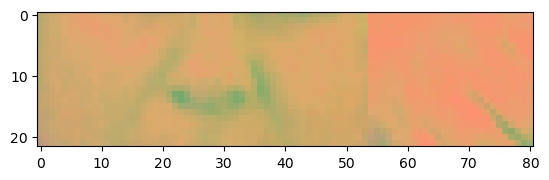

In [6]:
plt.imshow(YCrCb_Skin_samples)
plt.show()

In [7]:
# Estimate 2D-Gaussian according to CrCb samples

CrCb_Skin_samples = YCrCb_Skin_samples[:,:,1:].reshape((22*81,2))

print(CrCb_Skin_samples.shape)

# Maximum Likelihood estimation

mean_ML = np.sum(CrCb_Skin_samples, axis=0)/CrCb_Skin_samples.shape[0]
print(mean_ML)

Std_ML = np.matmul((CrCb_Skin_samples - mean_ML).T,(CrCb_Skin_samples - mean_ML))/CrCb_Skin_samples.shape[0]
print(Std_ML)


(1782, 2)
[0.64895048 0.42673753]
[[ 0.00075415 -0.00020361]
 [-0.00020361  0.00019106]]


In [8]:
def fd(CrCbIm, mean, Std):
    gauss2D = multivariate_normal(mean,Std)
    Skin = (gauss2D.pdf(CrCbIm) > 0.25).astype('uint8')
    
    kernel_small = np.ones((3, 3), np.uint8)
    kernel_big = np.ones((13, 13), np.uint8)
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_OPEN, kernel_small, iterations=1) # Opening
    
    Skin = cv2.morphologyEx(Skin, cv2.MORPH_CLOSE, kernel_big, iterations=1) # Closing
    
    Skin, num_features = label(Skin)
    
    plt.imshow(Skin)
    plt.show()
    
    Bounding_Boxes = []
    for i in range(1,num_features + 1):
        Bounding_Box = []
        Area = (Skin == i)
        Indeces = np.nonzero(Area)
        Bounding_Box.append(min(Indeces[1]))
        Bounding_Box.append(min(Indeces[0]))
        Bounding_Box.append(max(Indeces[1]) - min(Indeces[1]))
        Bounding_Box.append(max(Indeces[0]) - min(Indeces[0]))
        Bounding_Boxes.append(Bounding_Box)
        
    return Bounding_Boxes
    

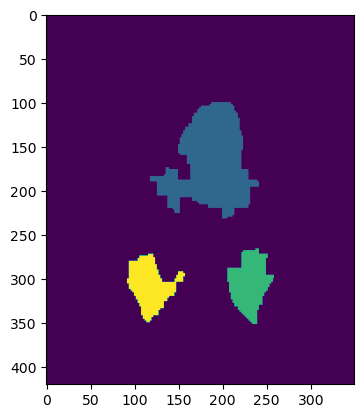

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[118, 100, 123, 131], [206, 266, 52, 85], [92, 272, 65, 77]]
(420, 350, 3)


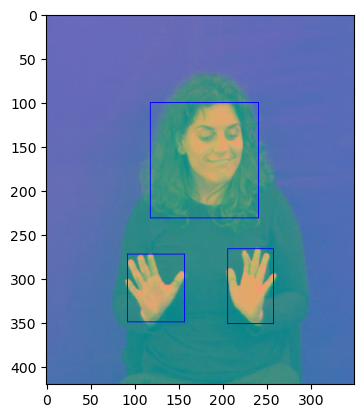

In [9]:
Bounding_Boxes = fd(YCrCbIm[:,:,1:],mean_ML,Std_ML)

print(Bounding_Boxes)

for Bounding_Box in Bounding_Boxes:
    x = Bounding_Box[0]
    y = Bounding_Box[1]
    w = Bounding_Box[2]
    h = Bounding_Box[3]
    YCrCbIm = cv2.rectangle(YCrCbIm, (x,y), (x+w,y+h), (0,0,255), 1)
    
print(YCrCbIm.shape)
    
# Displaying the image 
plt.imshow(YCrCbIm)
plt.show()

### 1.1.2

In [10]:
def Gaussian_Filters_v2(sigma):                          #from lab1
    n = int(np.ceil(3 * sigma) * 2 + 1)
    Gaussian_1D = cv2.getGaussianKernel(n, sigma)
    Gaussian = Gaussian_1D @ Gaussian_1D.T
    return Gaussian

def lk(I1, I2, features, rho, epsilon, d_x0, d_y0):   #Lucas-Kanade algorithm implementation
    
    grad_y, grad_x = np.gradient(I1)
    
    gaussian = Gaussian_Filters_v2(rho)
    
    d_final = []
    
    height, width = I1.shape
    x_0, y_0 = np.meshgrid(np.arange(width), np.arange(height))
    
    for i in range(features.shape[0]):
        
        dx = d_x0
        dy = d_y0
        u = np.array([[100.0],        #initializing u with a high value (2x1 vector)
                      [100.0]])
        x = features[i][0][0]
        y = features[i][0][1]
        
        tolerance = 1e-4  #the tolerance level for convergence
        
        prev_dx = 10
        prev_dy = 10
        
        while np.abs(dx - prev_dx) > tolerance or np.abs(dy - prev_dy) > tolerance: #criterion of convergence
            
            prev_dx = dx
            prev_dy = dy
            
            I1_d = map_coordinates(I1, [y_0 + dy, x_0 + dx], order=1, mode='nearest').reshape(I1.shape)
            a2 = map_coordinates(grad_y, [y_0 + dy, x_0 + dx], order=1, mode='nearest').reshape(I1.shape)
            a1 = map_coordinates(grad_x, [y_0 + dy, x_0+ dx], order=1, mode='nearest').reshape(I1.shape)
            
            e = I2 - I1_d
            
            inv11 = cv2.filter2D(a1**2, -1, gaussian) + epsilon
            inv21 = cv2.filter2D(a1 * a2, -1, gaussian)
            inv12 = inv21
            inv22 = cv2.filter2D(a2**2, -1, gaussian) + epsilon
            
            invArray = np.array([[inv11[y, x], inv12[y, x]],
                                 [inv21[y, x], inv22[y, x]]])
            
            newArray = np.linalg.inv(invArray) #computing the inverse of invArray
            
            norm1 = cv2.filter2D(a1 * e, -1, gaussian)
            norm2 = cv2.filter2D(a2 * e, -1, gaussian)
            
            normArray = np.array([[norm1[y, x]],
                                  [norm2[y, x]]])
            
            u = newArray @ normArray

            dy = dy + u[1, 0]
            dx = dx + u[0, 0]

        d_final.append([-dx, -dy])
    
    return d_final

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350)
Range: 2 - 240 


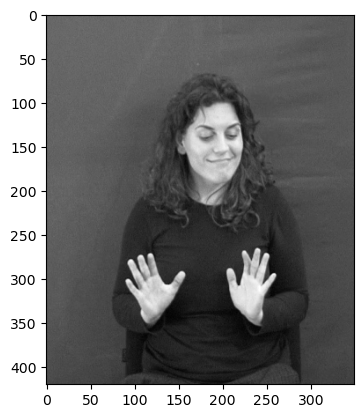

Image loaded as:  <class 'numpy.ndarray'>
Resolution:  (420, 350)
Range: 3 - 237 


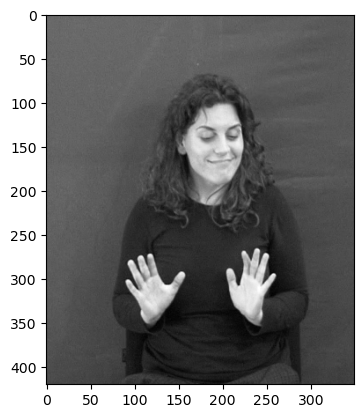

In [11]:
#1st image

grayIm = cv2.cvtColor(Im, cv2.COLOR_BGR2GRAY)

print("Image loaded as: ", type(grayIm))
print("Resolution: ", grayIm.shape)
print("Range: %d - %d " % (np.min(grayIm), np.max(grayIm)))

# Normalize to [0,1]
grayIm = grayIm.astype(np.float32)/np.max(grayIm) #we need float32 type for "goodFeaturesToTrack" to work

plt.imshow(grayIm, cmap='gray')
plt.show()

#2nd image

Im2 = cv2.imread(".\\cv23_lab2_material\\part1 - GreekSignLanguage\\2.png")
grayIm2 = cv2.cvtColor(Im2, cv2.COLOR_BGR2GRAY)

print("Image loaded as: ", type(grayIm2))
print("Resolution: ", grayIm2.shape)
print("Range: %d - %d " % (np.min(grayIm2), np.max(grayIm2)))

# Normalize to [0,1]

grayIm2 = grayIm2.astype(np.float32)/np.max(grayIm2)

plt.imshow(grayIm2, cmap='gray')
plt.show()

In [49]:
#setting up bounding boxes

face_1 = grayIm[102:(115+102), 154:(154+67)]
left_1 = grayIm[272:(83+272), 93:(93+56)]
right_1 = grayIm[270:(83+270), 201:(201+56)]

face_2 = grayIm2[102:(115+102), 154:(154+67)]  #face_2 = grayIm[102-1:(115+102-1), 154-1:(154+67-1)] is used for debugging    
left_2 = grayIm2[272:(83+272), 93:(93+56)]
right_2 = grayIm2[270:(83+270), 201:(201+56)]

#computing corners

corners = cv2.goodFeaturesToTrack(left_1, 1000, 0.1, 0.1)
corners = np.int0(corners)

The average of all d's is [-0.0959507   0.48927532]


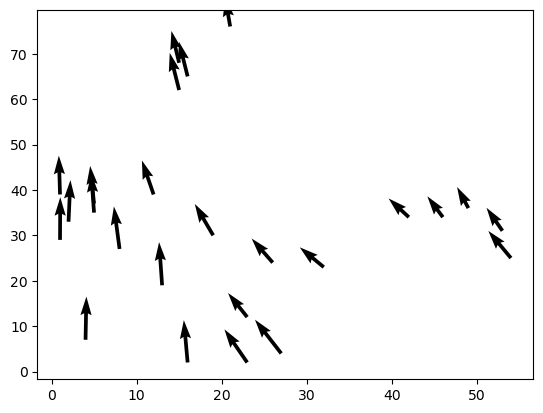

In [51]:
#evaluating & visualizing optical flow using Lucas-Kanade method

d = lk(left_1, left_2, corners, 5, 0.01, -0.09594864,  0.48927384)  

print("The average of all d's is",np.mean(d, axis=0)) #we print the average of d's in order to save space

x = corners[:, 0, 0]
y = corners[:, 0, 1]

dx, dy = zip(*d)

plt.quiver(x, y, dx, dy, angles='xy', scale=7)
plt.show()

Σημειώσεις:

1) Η υλοποίησή μας δουλεύει καλά για μεγάλο "ρ" και μικρή σταθερά "ε". Περαιτέρω αύξηση του "ρ" άνω του 5 δε δίνει καλύτερα αποτελέσματα.

2) Η αρχική εκτίμηση για το διάνυσμα "d" μπορεί να είναι τυχαία. Τρέχοντας τον αλγόριθμο για 1η φορά, θα παρατηρήσουμε ότι έχουμε εν γένει μεγάλες αποκλίσεις σε κάποιες γωνίες. Το πρόβλημα αυτό λύνεται υπολογίζοντας τη μέση τιμή όλων των "d" και βάζοντας αυτή ως αρχική εκτίμηση τη 2η φορά που τρέχουμε τον αλγόριθμο. Τα αποτελέσματα που προκύπτουν είναι πολύ ικανοποιητικά.

The average optical flow is [-0.08210476  0.5208058 ]


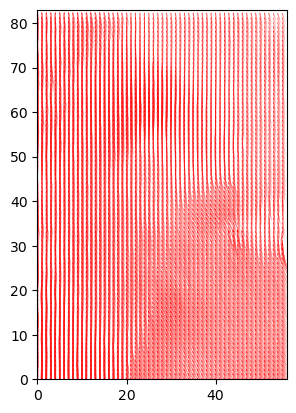

In [56]:
#computing & visualizing optical flow using TV-L1 from OpenCV

optical_flow = cv2.DualTVL1OpticalFlow_create()

flow = optical_flow.calc(left_1, left_2, None)

print("The average optical flow is", np.mean(np.mean(flow, axis=0), axis=0)) #we compare this with the average value of d's


flow_x = flow[..., 0]
flow_y = flow[..., 1]

h, w = flow.shape[:2]
x = np.arange(0, w, 1)
y = np.arange(0, h, 1)
x, y = np.meshgrid(x, y)

plt.quiver(x, y, flow_x, flow_y, color='r', angles='xy', scale_units='xy', scale=1, headaxislength=40, headlength=5)

plt.xlim([0, w])
plt.ylim([0, h])
plt.gca().set_aspect('equal', adjustable='box')

plt.show()

### 1.1.3